In [359]:
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from collections import Counter
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [360]:
ft_epochs = torch.arange(4, 100, 5)
abs_distances_pre: torch.Tensor = torch.load('./trained_models/distances_solid_absolute_pre.pt', map_location='cpu')
abs_distances_ft: torch.Tensor = [
    torch.load(f'./trained_models/distances_solid_absolute_{i}.pt', map_location='cpu')
    for i in ft_epochs
]
abs_distances_pre.size()
ft_epochs

tensor([ 4,  9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89,
        94, 99])

In [361]:
l2s = range(10)
borders = range(10)
centers = [0, 1, 2, 4, 5, 6, 7, 8, 9]
l2_files = [
    torch.load(f'./trained_models/distances_l2_border_stl10_perturb_0.{i}.pt')
    for i in l2s
]
border_files = [
    torch.load(f'./trained_models/distances_border_stl10_perturb_0.{i}.pt')
    for i in borders
]
center_files = [
    torch.load(f'./trained_models/distances_center_stl10_perturb_0.{i}.pt')
    for i in centers
]

In [362]:
deltas = [0.1, 0.05, 0.005]
l2_delta_mems = {delta : [torch.sum(l2_files[i] / 30 < delta) for i in range(len(l2_files))] for delta in deltas}
border_delta_mems = {delta : [torch.sum(border_files[i] < delta) for i in range(len(border_files))] for delta in deltas}
center_delta_mems = {delta : [torch.sum(center_files[i] < delta) for i in range(len(center_files))] for delta in deltas}

In [363]:
for delta in deltas:
    print(f"Delta: {delta}; Border: {border_delta_mems[delta][0]}; Center: {center_delta_mems[delta][0]}")
    print(f"L2: {l2_delta_mems[delta][0]}")

Delta: 0.1; Border: 1879; Center: 1927
L2: 10000
Delta: 0.05; Border: 977; Center: 1011
L2: 1095
Delta: 0.005; Border: 81; Center: 107
L2: 0


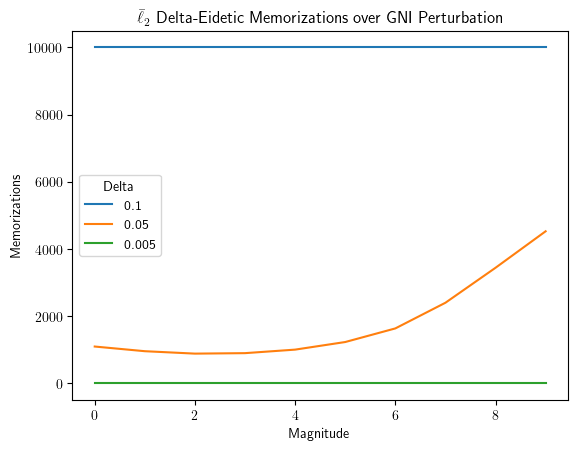

In [364]:
for i, delta in enumerate(deltas):
    plt.plot(l2s, l2_delta_mems[delta], label=delta)
plt.legend(title="Delta")
plt.title("$\\bar{\ell}_2$ Delta-Eidetic Memorizations over GNI Perturbation")
plt.xlabel("Magnitude")
plt.ylabel("Memorizations")
plt.show()

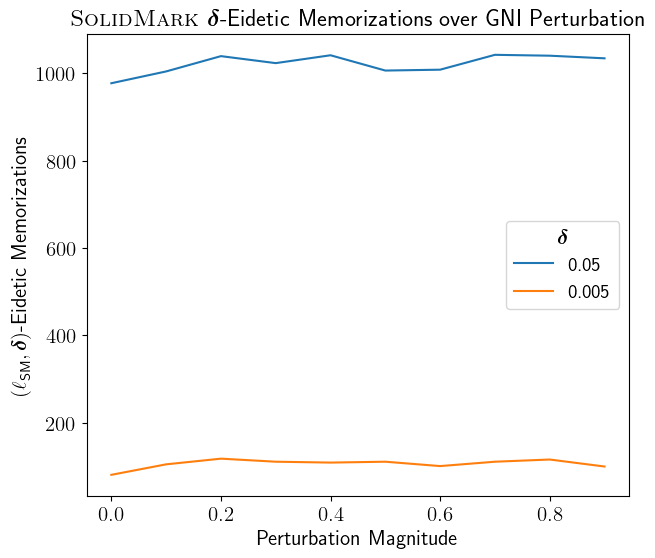

In [365]:
deltas = [0.05, 0.005]
plt.figure(figsize=(7, 6))
for i, delta in enumerate(deltas):
    plt.plot([border / 10 for border in borders], border_delta_mems[delta], label=delta)
leg=plt.legend(title=r"$\boldsymbol{\delta}$",fontsize=14)
plt.setp(leg.get_title(),fontsize='15')
plt.title(r"$\textsc{SolidMark}$ $\boldsymbol{\delta}$-Eidetic Memorizations over GNI Perturbation", fontsize=17)
plt.xlabel("Perturbation Magnitude", fontsize=15)
plt.ylabel(r"$(\ell_{\text{SM}}, \boldsymbol{\delta})$-Eidetic Memorizations", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

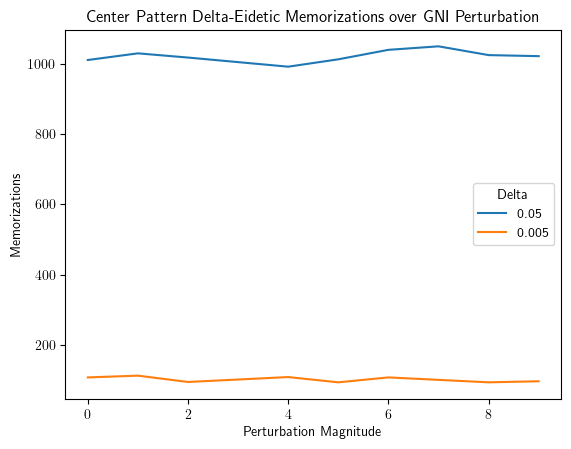

In [366]:
for i, delta in enumerate(deltas):
    plt.plot(centers, center_delta_mems[delta], label=delta)
plt.legend(title="Delta")
plt.title("Center Pattern Delta-Eidetic Memorizations over GNI Perturbation")
plt.xlabel("Perturbation Magnitude")
plt.ylabel("Memorizations")
plt.show()

In [367]:
deltas = [0.01, 0.001]
delta_mems = {delta : torch.sum(abs_distances_pre < delta) for delta in deltas}
delta_mems

{0.01: tensor(163), 0.001: tensor(24)}

In [368]:
ft_epochs = torch.cat((torch.tensor([0]), ft_epochs))
abs_distances_ft = [abs_distances_pre] + abs_distances_ft
accuracies: torch.Tensor = torch.tensor([torch.load(f'./trained_models/accuracy_{epoch}_0.001.pt', map_location='cpu') for epoch in ft_epochs])

In [369]:
deltas_per_ft = [
    [sum(distance < delta) for distance in abs_distances_ft]
    for delta in deltas
]

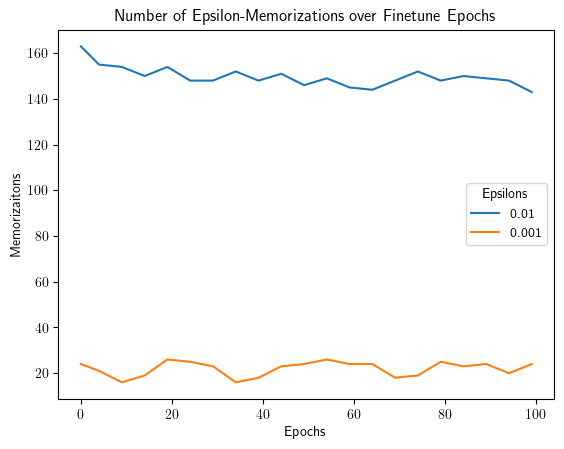

In [370]:
for i, delta in enumerate(deltas):
    plt.plot(ft_epochs, deltas_per_ft[i], label=delta)
plt.legend(title="Epsilons")
plt.title("Number of Epsilon-Memorizations over Finetune Epochs")
plt.xlabel("Epochs")
plt.ylabel("Memorizaitons")
plt.show()

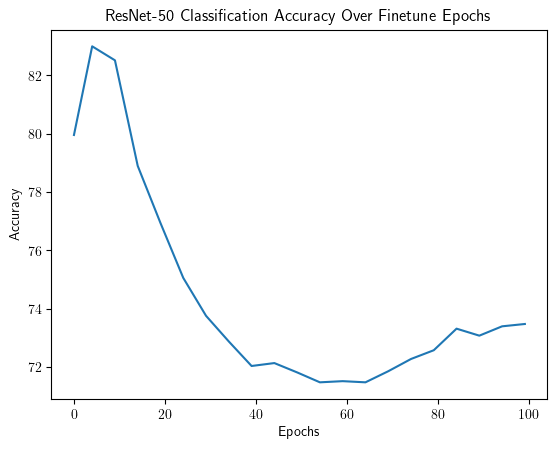

In [371]:
plt.plot(ft_epochs, accuracies)
plt.title("ResNet-50 Classification Accuracy Over Finetune Epochs")
plt.ylabel('Accuracy')
plt.xlabel("Epochs")
plt.show() 

In [372]:
ft_epochs = torch.arange(2, 22, 2)
mnist_epoch: int = 49 # MNIST Epoch - 1, so zero would be one epoch of FT
baseline_distances: torch.Tensor = abs_distances_pre
baseline_accuracy = accuracies[0]
abs_distances_ft: list[torch.Tensor] = [
    torch.load(f'./trained_models/distances_solid_absolute_mnist_{mnist_epoch}_{epoch}.pt', map_location='cpu')
    for epoch in ft_epochs
]
accuracies: torch.Tensor = torch.tensor([torch.load(f'./trained_models/accuracy_mnist_{mnist_epoch}_{epoch}.pt', map_location='cpu') for epoch in ft_epochs])
abs_distances_pre.size()
ft_epochs

tensor([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])

In [373]:
deltas_per_ft = [
    [sum(distance < delta) for distance in abs_distances_ft]
    for delta in deltas
]
baseline_deltas = [sum(baseline_distances < delta) for delta in deltas]

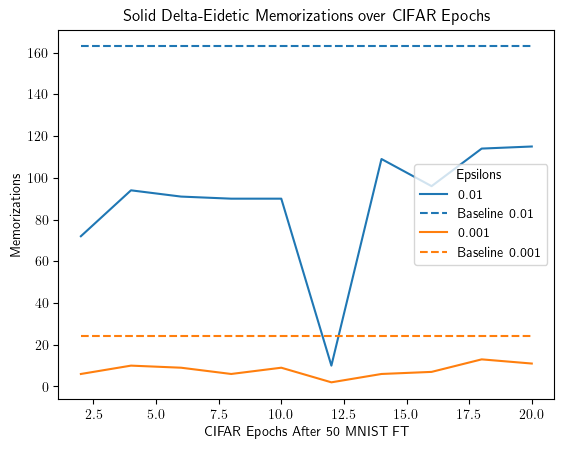

In [374]:
ax: Axes = plt.gca()
for i, delta in enumerate(deltas):
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(ft_epochs, deltas_per_ft[i], label=delta, color=color)
    plt.plot(ft_epochs, [baseline_deltas[i] for _ in ft_epochs], '--', label=f"Baseline {delta}", color=color)
plt.legend(title="Epsilons")
plt.title("Solid Delta-Eidetic Memorizations over CIFAR Epochs")
plt.xlabel(f"CIFAR Epochs After {mnist_epoch + 1} MNIST FT")
plt.ylabel("Memorizations")
plt.show()

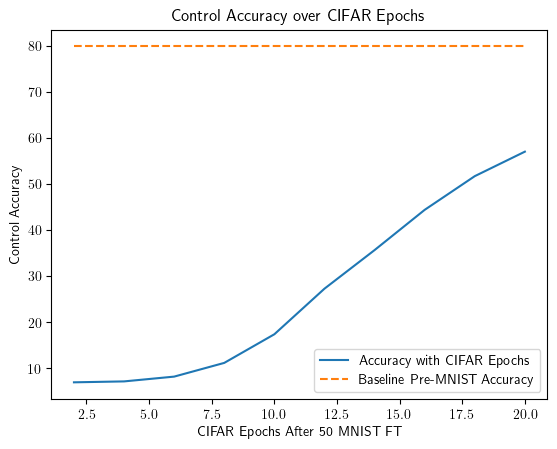

In [375]:
plt.plot(ft_epochs, accuracies, label="Accuracy with CIFAR Epochs")
plt.plot(ft_epochs, [baseline_accuracy for _ in ft_epochs], '--', label="Baseline Pre-MNIST Accuracy")
plt.title("Control Accuracy over CIFAR Epochs")
plt.xlabel(f"CIFAR Epochs After {mnist_epoch + 1} MNIST FT")
plt.ylabel("Control Accuracy")
plt.legend()
plt.show()

In [376]:
mnist_epochs = torch.arange(0, 50)
mnist_accuracies: torch.Tensor = torch.tensor([torch.load(f'./trained_models/accuracy_mnist_epoch_{epoch}.pt', map_location='cpu') for epoch in mnist_epochs])

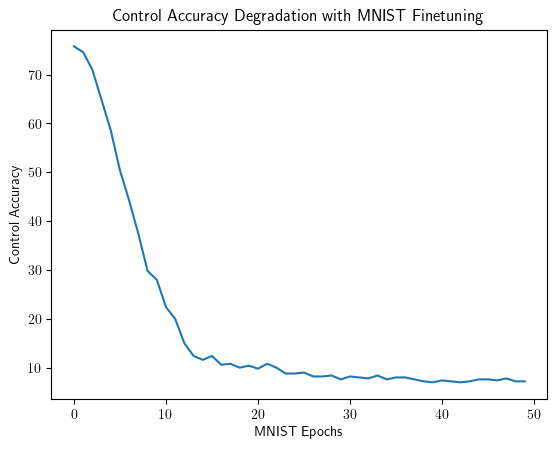

In [377]:
plt.plot(mnist_epochs, mnist_accuracies)
plt.xlabel("MNIST Epochs")
plt.ylabel("Control Accuracy")
plt.title("Control Accuracy Degradation with MNIST Finetuning")
plt.show()

In [378]:
gaussian_perturbs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
gaussian_distances: list[torch.Tensor] = [baseline_distances] + [
    torch.load(f'./trained_models/distances_solid_absolute_perturb_{i}.pt', map_location='cpu')
    for i in gaussian_perturbs
]
gaussian_perturbs = [0] + gaussian_perturbs
deltas_per_perturb = [
    [sum(distance < delta) for distance in gaussian_distances]
    for delta in deltas
]

In [379]:
print(deltas_per_perturb[0])
print(deltas_per_perturb[1])

[tensor(163), tensor(162), tensor(156), tensor(149), tensor(134), tensor(119), tensor(87), tensor(70)]
[tensor(24), tensor(16), tensor(20), tensor(20), tensor(16), tensor(17), tensor(9), tensor(8)]


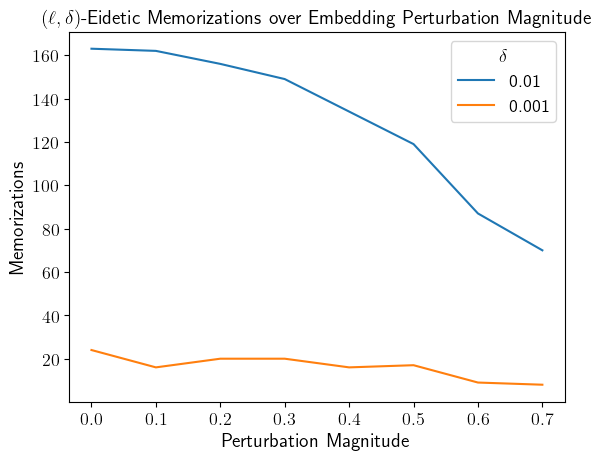

In [380]:
for i, delta in enumerate(deltas):
    plt.plot(gaussian_perturbs, deltas_per_perturb[i], label=delta)
leg = plt.legend(title="$\delta$", fontsize=13)
plt.setp(leg.get_title(),fontsize=13)
plt.title("$(\ell, \delta)$-Eidetic Memorizations over Embedding Perturbation Magnitude", fontsize=14)
plt.xlabel("Perturbation Magnitude", fontsize=14)
plt.ylabel("Memorizations", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

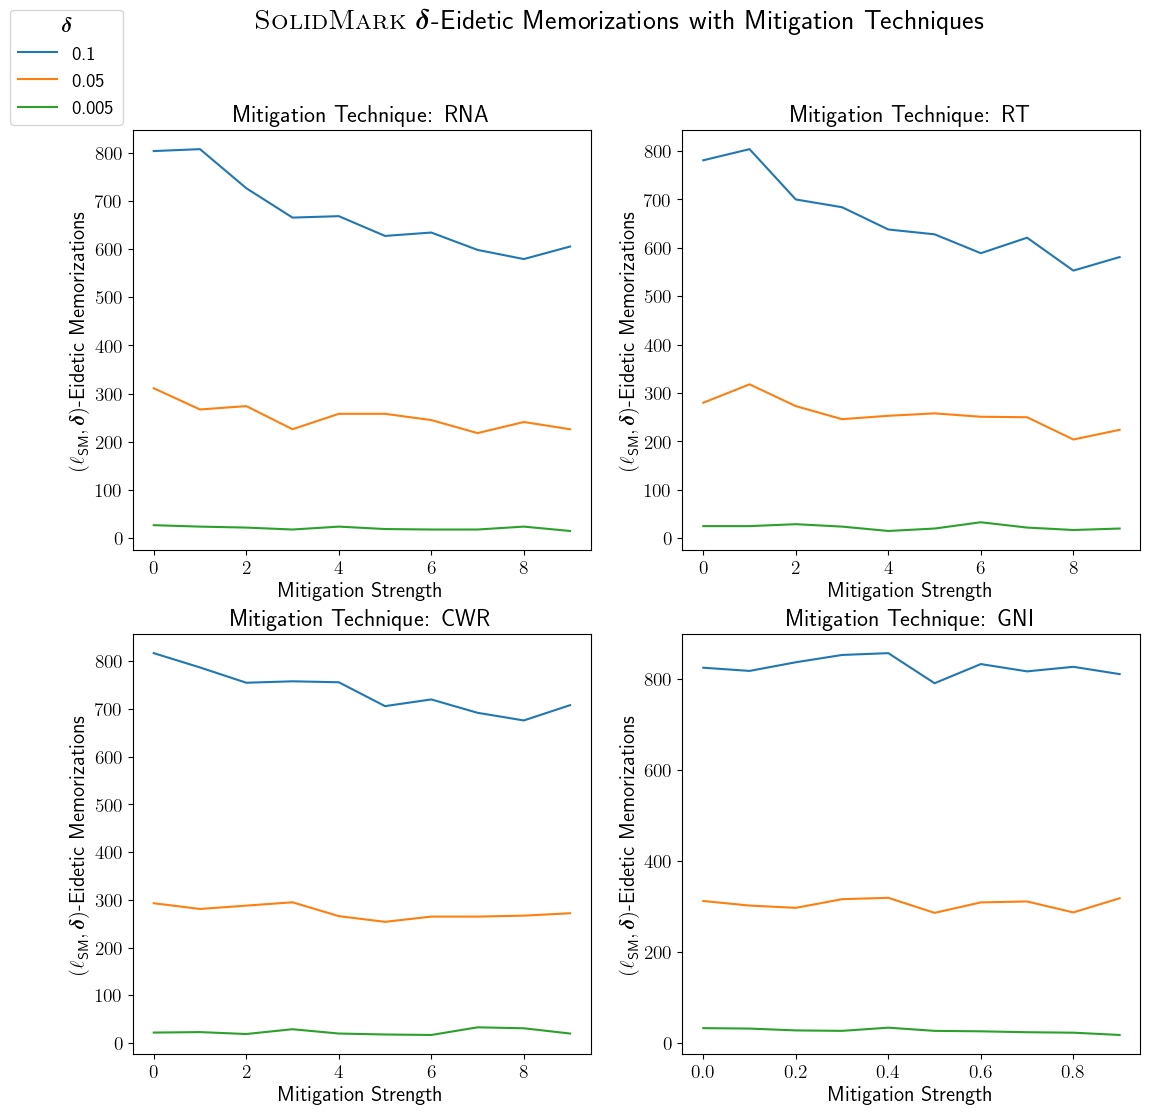

In [438]:
deltas = [0.1, 0.05, 0.005]
techniques_fig: Figure; techniques_axs: Axes
techniques_fig, techniques_axs = plt.subplots(2, 2)
techniques_fig.set_figheight(12)
techniques_fig.set_figwidth(13)
techniques = ["RNA", "RWA", "CWR", "gaussian"]
perturbs = range(10)
distances = {
    tech:
        [
            torch.load(f'./trained_models/distances_sd_{tech}_{i}.pt', map_location='cpu') 
            for i in perturbs
        ]
    for tech in techniques
}
deltas_per_perturb = {
    tech:
        [
            [sum(distance < delta) for distance in distances[tech]]
            for delta in deltas
        ]
    for tech in techniques
}
delta_latex = r"$\boldsymbol{\delta}$"
sm = r"$\textsc{SolidMark}$"
techniques_fig.suptitle(f"{sm} {delta_latex}-Eidetic Memorizations with Mitigation Techniques", fontsize=20)
for i, tech in enumerate(techniques):
    ax = techniques_axs[i // 2][i % 2]
    for j, delta in enumerate(deltas):
        if tech == "gaussian":
            ax.plot([perturb / 10 for perturb in perturbs], deltas_per_perturb[tech][j], label=delta)
        else:
            ax.plot(perturbs, deltas_per_perturb[tech][j], label=delta)
        name = tech
        if tech == "gaussian":
            name = "GNI"
        elif tech == "RWA":
            name = "RT"
        ax.set_title(f"Mitigation Technique: {name}", fontsize=17)
        ax.set_xlabel("Mitigation Strength", fontsize=15)
        ax.set_ylabel(r"$(\ell_{\text{SM}}, \boldsymbol{\delta})$-Eidetic Memorizations", fontsize=15)
        ax.tick_params(axis='both', which='major', labelsize=14)
leg = techniques_axs[0][0].legend(title=delta_latex, bbox_to_anchor=(0, 1.31), fontsize=14)
plt.setp(leg.get_title(), fontsize=15)
plt.show()

In [382]:
def plot_technique(perturbs: torch.Tensor, name: str, deltas: list[int]):
    distances: list[torch.Tensor] = [
    torch.load(f'./trained_models/distances_sd_{name}_{i}.pt', map_location='cpu')
    for i in perturbs
    ]
    if name == "gaussian":
        name = "Gaussian"
    elif name == "RWA":
        name = "RT"
    deltas_per_perturb = [
        [sum(distance < delta) for distance in distances]
        for delta in deltas
    ]
    for perturb in deltas_per_perturb:
        print(perturb)
    if name == "Gaussian":
        perturbs = [perturb for perturb in perturbs / 10]
    for i, delta in enumerate(deltas):
        plt.plot(perturbs, deltas_per_perturb[i], label=delta)
        delta = r"$\boldsymbol{\delta}$"
        leg = plt.legend(title=delta, fontsize=14, loc='right')
        plt.setp(leg.get_title(),fontsize=15)
        sm = r"$\textsc{SolidMark}$"
        plt.title(f"{sm} {delta}-Eidetic Memorizations over {name} Mitigation Strength", fontsize=17)
        plt.xlabel("Mitigation Strength", fontsize=15)
        plt.ylabel(r"$(\ell_{\text{SM}}, \boldsymbol{\delta})$-Eidetic Memorizations", fontsize=15)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
    plt.show()

[tensor(781), tensor(804), tensor(700), tensor(684), tensor(638), tensor(628), tensor(589), tensor(621), tensor(553), tensor(581)]
[tensor(280), tensor(318), tensor(273), tensor(246), tensor(253), tensor(258), tensor(251), tensor(250), tensor(204), tensor(224)]
[tensor(25), tensor(25), tensor(29), tensor(24), tensor(15), tensor(20), tensor(33), tensor(22), tensor(17), tensor(20)]


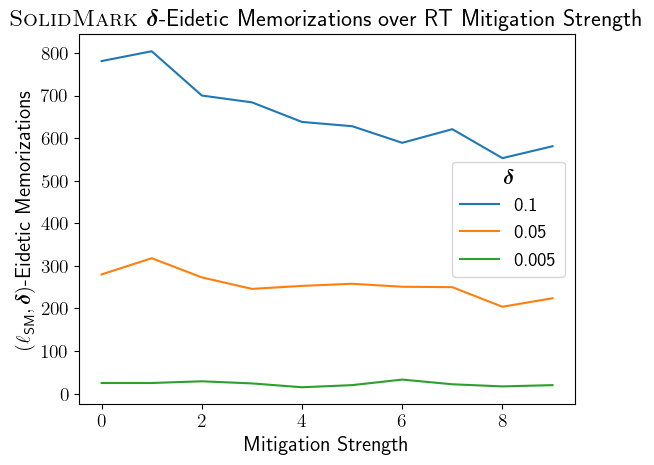

In [383]:
plot_technique(torch.arange(10), "RWA", deltas)

[tensor(803), tensor(807), tensor(726), tensor(665), tensor(668), tensor(627), tensor(634), tensor(598), tensor(579), tensor(605)]
[tensor(311), tensor(267), tensor(274), tensor(226), tensor(258), tensor(258), tensor(245), tensor(218), tensor(241), tensor(226)]
[tensor(27), tensor(24), tensor(22), tensor(18), tensor(24), tensor(19), tensor(18), tensor(18), tensor(24), tensor(15)]


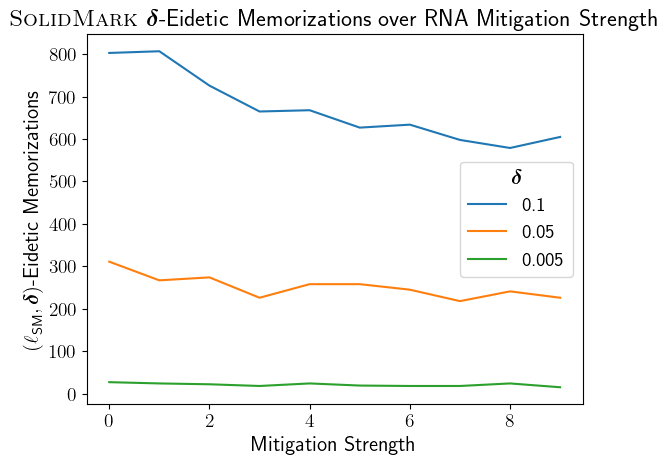

In [384]:
plot_technique(torch.arange(10), "RNA", deltas)

[tensor(817), tensor(787), tensor(755), tensor(758), tensor(756), tensor(706), tensor(720), tensor(692), tensor(676), tensor(708)]
[tensor(293), tensor(281), tensor(288), tensor(295), tensor(266), tensor(254), tensor(265), tensor(265), tensor(267), tensor(272)]
[tensor(22), tensor(23), tensor(19), tensor(29), tensor(20), tensor(18), tensor(17), tensor(33), tensor(31), tensor(20)]


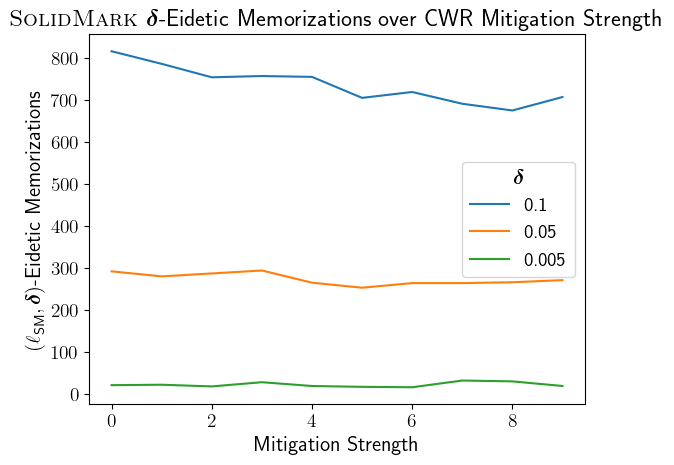

In [385]:
plot_technique(torch.arange(10), "CWR", deltas)

[tensor(824), tensor(817), tensor(836), tensor(852), tensor(856), tensor(790), tensor(832), tensor(816), tensor(826), tensor(810)]
[tensor(312), tensor(302), tensor(297), tensor(316), tensor(319), tensor(286), tensor(309), tensor(311), tensor(287), tensor(318)]
[tensor(33), tensor(32), tensor(28), tensor(27), tensor(34), tensor(27), tensor(26), tensor(24), tensor(23), tensor(18)]


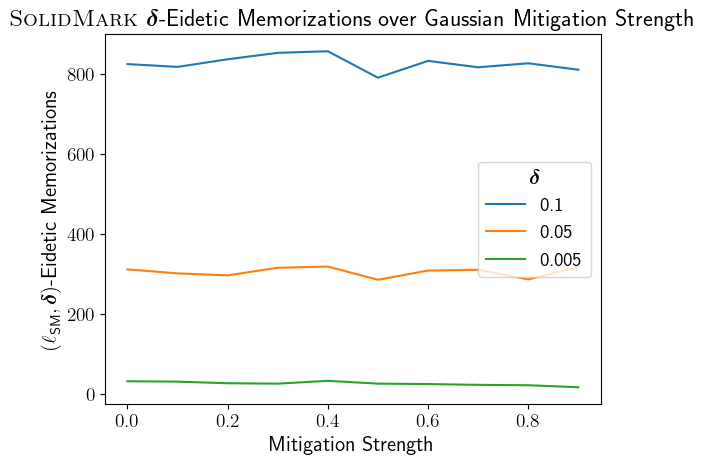

In [386]:
plot_technique(torch.arange(10), "gaussian", deltas)

In [387]:
pretrained_ckpts = list(range(1, 167)) + list(range(168, 200))
# pretrained_ckpts = range(1, 200)
ckpts = [ckpt * 2500 for ckpt in pretrained_ckpts]
ckpt_files = [torch.load(f'./trained_models/distances_sd_pretrain_ckpt_{ckpt}.pt', map_location='cpu') for ckpt in ckpts]
deltas = [0.05, 0.005]

In [388]:
delta_mems = {
    delta: [torch.sum(ckpt < delta) for ckpt in ckpt_files] for delta in deltas
}

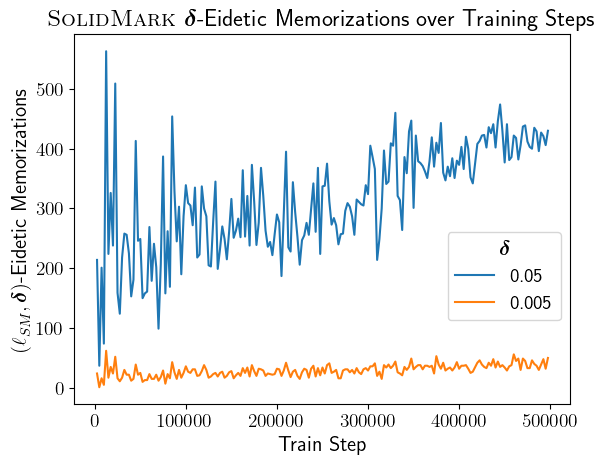

In [389]:
for i, delta in enumerate(deltas):
    plt.plot(ckpts, delta_mems[delta], label=delta)
leg = plt.legend(title=r"$\boldsymbol{\delta}$", fontsize=14, bbox_to_anchor=(1.0, 0.2), loc='lower right')
plt.setp(leg.get_title(),fontsize=15)
plt.title(r"$\textsc{SolidMark}$ $\boldsymbol{\delta}$-Eidetic Memorizations over Training Steps", fontsize=17)
plt.xlabel("Train Step", fontsize=15)
plt.ylabel(r"$(\ell_{SM}, \boldsymbol{\delta})$-Eidetic Memorizations", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [390]:
distances_avg = [
    torch.load(f'./trained_models/distances_sd_dup_avg_{i}.pt', map_location='cpu') for i in range(1, 10)
]
distances_nearest = [
    torch.load(f'./trained_models/distances_sd_dup_nearest_{i}.pt', map_location='cpu') for i in range(1, 10)
]
mems = [
    torch.load(f'./trained_models/distances_sd_dup_mem_{i}.pt', map_location='cpu') for i in range(1, 10)
]

In [391]:
deltas = [0.1, 0.05, 0.005]
avgs_deltas = {
    delta : [
        torch.sum(v < delta) for v in distances_avg
    ] for delta in deltas
}
nrst_deltas = {
    delta : [
        torch.sum(v < delta) for v in distances_nearest
    ] for delta in deltas
}

In [392]:
for delta in deltas:
    print(nrst_deltas[delta][:3])

[tensor(152), tensor(238), tensor(278)]
[tensor(81), tensor(141), tensor(130)]
[tensor(12), tensor(12), tensor(11)]


In [393]:
print(mems[0])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [394]:
mems_per_delta = {delta: [] for delta in deltas}
for delta in deltas:
    for i in range(len(mems)):
        mems_per_delta[delta].append([mems[i][j].item() if distances_nearest[i][j] < delta else -1 for j in range(mems[i].size(0))])

In [395]:
print(distances_avg[0])

tensor([0.0776, 0.0913, 0.0787, 0.2787, 0.2078, 0.2512, 0.2771, 0.0632, 0.2324,
        0.0295, 0.1064, 0.1053, 0.0831, 0.0962, 0.0763, 0.0942, 0.1176, 0.1000,
        0.0958, 0.0844, 0.1561, 0.1010, 0.1351, 0.1086, 0.1327, 0.1035, 0.1781,
        0.1499, 0.1095, 0.2044, 0.0664, 0.0244, 0.2925, 0.0584, 0.0468, 0.2535,
        0.0282, 0.0183, 0.0885, 0.0515, 0.0085, 0.1865, 0.2687, 0.0059, 0.2697,
        0.0123, 0.0064, 0.0065, 0.2724, 0.0165, 0.2555, 0.2322, 0.2157, 0.2246,
        0.2377, 0.1940, 0.2378, 0.2157, 0.2522, 0.2514, 0.1797, 0.0226, 0.1892,
        0.1206, 0.2352, 0.1484, 0.0293, 0.2694, 0.1502, 0.1517, 0.5472, 0.5882,
        0.5475, 0.5112, 0.5911, 0.5541, 0.5982, 0.5847, 0.5992, 0.5819, 0.1735,
        0.0394, 0.0236, 0.2915, 0.0199, 0.0115, 0.1978, 0.1447, 0.2795, 0.0508,
        0.3530, 0.3486, 0.2068, 0.3239, 0.2158, 0.3176, 0.3537, 0.3762, 0.2768,
        0.2494, 0.1588, 0.1562, 0.2090, 0.1781, 0.1760, 0.1375, 0.1678, 0.5057,
        0.1545, 0.1481, 0.0063, 0.0544, 

In [396]:
avgs_per_delta = {delta: [] for delta in deltas}
for delta in deltas:
    for i in range(len(mems)):
        avgs_per_delta[delta].append([0 if distances_avg[i][j] < delta else -1 for j in range(mems[i].size(0))])
avgs_per_delta = {
    k : [[lst[x:x+10] for x in range(0, len(lst), 10)] for lst in v] for k, v in avgs_per_delta.items()
}
print(avgs_per_delta[0.1])

[[[0, 0, 0, -1, -1, -1, -1, 0, -1, 0], [-1, -1, 0, 0, 0, 0, -1, -1, 0, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [0, 0, -1, 0, 0, -1, 0, 0, 0, 0], [0, -1, -1, 0, -1, 0, 0, 0, -1, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, 0, -1, -1, -1, -1, 0, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, 0, 0, -1, 0, 0, -1, -1, -1, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [0, 0, -1, -1, -1, -1, 0, -1, -1, 0], [0, -1, -1, -1, -1, -1, 0, -1, -1, -1], [0, 0, -1, -1, 0, 0, 0, 0, -1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, 0, -1, 0, 0, -1, 0, -1, -1, 0], [0, -1, -1, -1, 0, -1, -1, -1, 0, -1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, 0, 0, -1, -1, -1, -1, -1], [0, 0, 0, 0, 0, 0, -1, -1, -1, -1], [-1, -1, 0, 0, -1, -1, -1, -1, 0, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, 0, -1, 0, -1, 0, 0, -1, 0, -1], [0, -1, -1, -1, 0, -1, -1, -1, -1, -1], [0, 0, 0, 0, 0, 0, 0, -1, 0, -1], [0, -

In [397]:
mems_per_delta = {
    k : [[lst[x:x+10] for x in range(0, len(lst), 10)] for lst in v] for k, v in mems_per_delta.items()
}

In [398]:
def avg(iterable):
    return sum(iterable) / len(iterable)

In [399]:
conf_per_delta = {
    delta: [[sum(instance != -1 for instance in ten) for ten in dup] for dup in mems_per_delta[delta]] for delta in deltas
}
conf_per_delta = {
    delta: [avg([ten for ten in dup if ten != 0]) for dup in conf_per_delta[delta]] for delta in deltas
}
conf_per_delta

{0.1: [4.75,
  6.4324324324324325,
  7.315789473684211,
  7.666666666666667,
  8.395348837209303,
  8.609756097560975,
  9.477272727272727,
  9.066666666666666,
  9.693877551020408],
 0.05: [3.857142857142857,
  4.862068965517241,
  4.482758620689655,
  6.878787878787879,
  6.527777777777778,
  6.483870967741935,
  7.487804878048781,
  7.617647058823529,
  8.022222222222222],
 0.005: [1.5,
  1.2,
  1.2222222222222223,
  1.6,
  2.0,
  2.7333333333333334,
  1.7647058823529411,
  2.4545454545454546,
  2.375]}

In [400]:
uniques_per_delta = {
    k : [[len(set(keys)) - 1 for keys in dup] for dup in v] for k, v in mems_per_delta.items()
}

In [401]:
freqs_per_delta = {
    k : [dict(Counter(uniques)) for uniques in v] for k, v in uniques_per_delta.items()
}

In [402]:
print(freqs_per_delta[0.05])

[{0: 26, 2: 6, 1: 14}, {0: 22, 1: 19, 2: 7, 3: 1}, {0: 19, 2: 6, 1: 21}, {1: 17, 0: 24, 2: 7}, {2: 11, 1: 18, 3: 1, 0: 19}, {0: 26, 1: 12, 3: 2, 2: 5, 5: 3}, {1: 20, 0: 15, 3: 2, 2: 12}, {0: 20, 3: 2, 1: 17, 2: 5, 4: 3}, {4: 6, 0: 13, 1: 19, 3: 3, 2: 7, 5: 1}]


In [403]:
found_per_delta = {
    delta: [sum([instance > 0 for instance in dup]) for dup in uniques_per_delta[delta]] for delta in deltas
}

In [404]:
found_per_delta

{0.1: [28, 32, 26, 26, 29, 26, 27, 27, 33],
 0.05: [20, 27, 27, 24, 30, 22, 34, 27, 36],
 0.005: [8, 10, 9, 10, 17, 15, 17, 11, 24]}

In [405]:
found_avgs_per_delta = {
    delta: [sum([0 in instance for instance in dup]) for dup in avgs_per_delta[delta]] for delta in deltas
}

In [406]:
found_avgs_per_delta

{0.1: [28, 31, 30, 23, 25, 24, 28, 30, 25],
 0.05: [20, 23, 21, 10, 20, 15, 18, 22, 16],
 0.005: [4, 6, 6, 1, 3, 1, 8, 9, 3]}